In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import copy
import seaborn as sns
from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

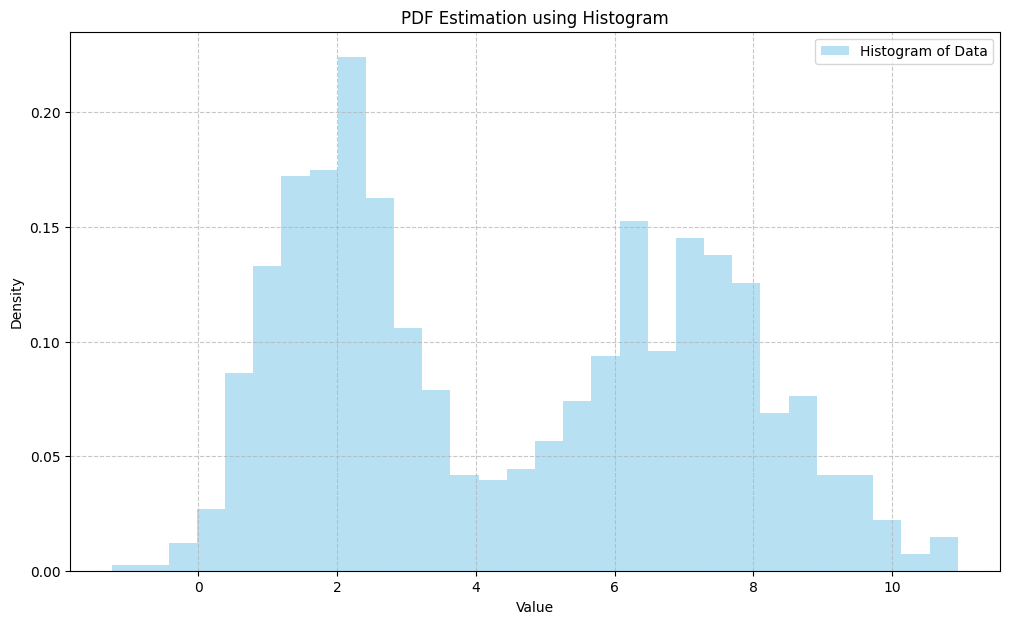

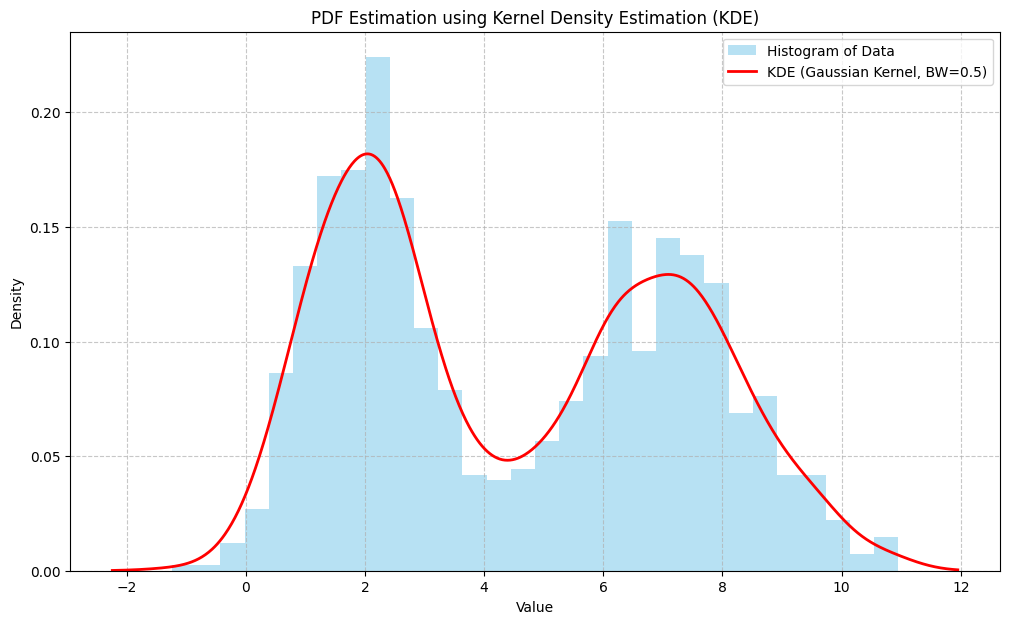

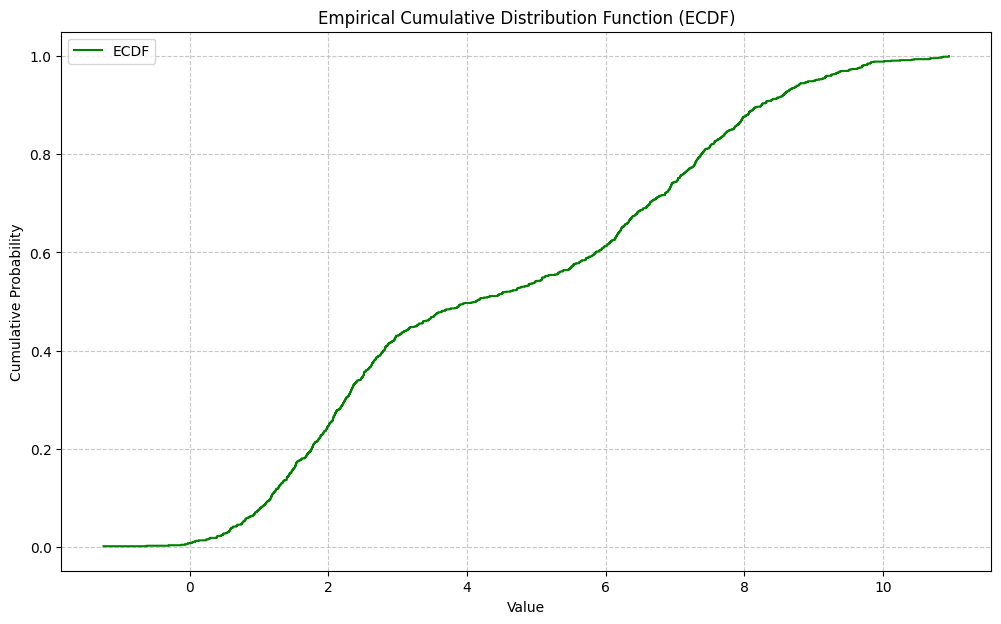

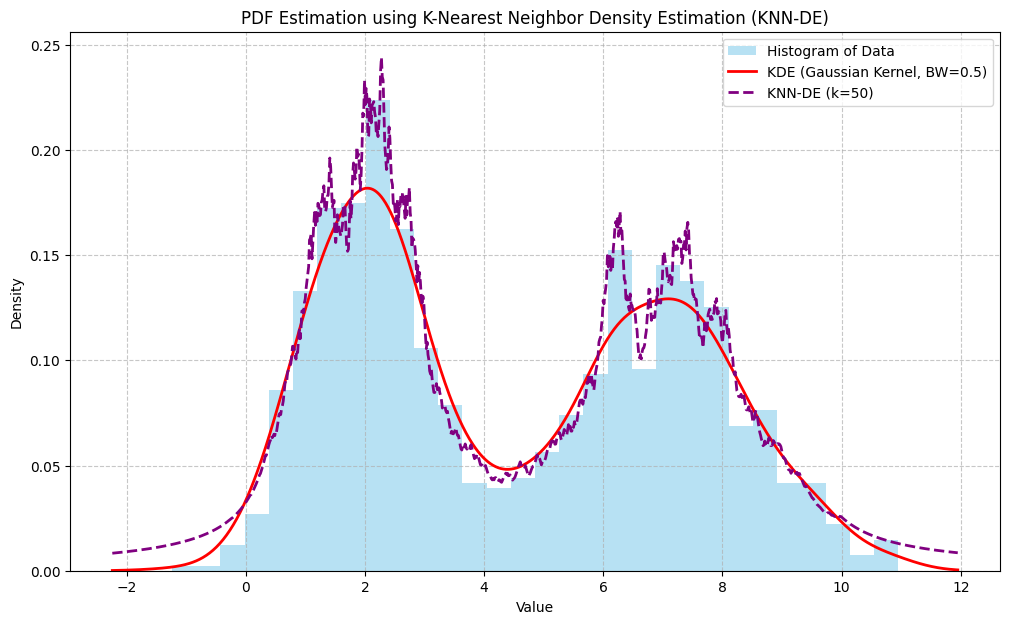


Estimated P(3 <= X <= 6) using KDE: 0.2118
Estimated P(3 <= X <= 6) using KNN-DE: 0.1936
Estimated P(3 <= X <= 6) directly from raw data: 0.1830


C:\Users\emper\AppData\Local\Temp\ipykernel_21564\2090309801.py:123: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  probability_kde = np.trapz(np.exp(log_dens[idx_start:idx_end+1]), x=x_plot[idx_start:idx_end+1].flatten())
C:\Users\emper\AppData\Local\Temp\ipykernel_21564\2090309801.py:127: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  probability_knn_de = np.trapz(knn_densities[idx_start:idx_end+1], x=x_plot[idx_start:idx_end+1].flatten())


In [2]:
# สำหรับ KNN-DE เราจะสร้างฟังก์ชันขึ้นมาเอง เนื่องจาก scikit-learn ไม่มีในตัว (แต่มีแนวคิดที่คล้ายกันใน LocalOutlierFactor)
# อย่างไรก็ตาม, สำหรับการประมาณความหนาแน่นโดยตรง, มักจะใช้ KernelDensity

# --- 1. สร้างข้อมูลตัวอย่าง ---
np.random.seed(42) # เพื่อให้ผลลัพธ์ repeatable

# สร้างข้อมูลจาก Normal Distribution สองชุด
data_1 = np.random.normal(loc=2, scale=1, size=500)  # ค่าเฉลี่ย 2, ส่วนเบี่ยงเบนมาตรฐาน 1
data_2 = np.random.normal(loc=7, scale=1.5, size=500) # ค่าเฉลี่ย 7, ส่วนเบี่ยงเบนมาตรฐาน 1.5

# รวมข้อมูลทั้งสองชุด
data = np.concatenate((data_1, data_2))

# Reshape ข้อมูลสำหรับ sklearn (ต้องเป็น 2D array)
data_reshaped = data[:, np.newaxis]

# สร้างช่วง x-axis สำหรับพล็อต PDF
x_plot = np.linspace(min(data) - 1, max(data) + 1, 1000)[:, np.newaxis]

# --- 2. การประมาณ PDF ด้วยวิธีต่างๆ ---

## 2.1 ฮิสโตแกรม (Histogram)
plt.figure(figsize=(12, 7))
plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram of Data')
plt.title('PDF Estimation using Histogram')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2.2 Kernel Density Estimation (KDE)
# สร้างโมเดล KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_reshaped)

# คำนวณ log-density สำหรับแต่ละจุดใน x_plot
log_dens = kde.score_samples(x_plot)

plt.figure(figsize=(12, 7))
plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram of Data')
plt.plot(x_plot, np.exp(log_dens), color='red', linestyle='-', linewidth=2, label='KDE (Gaussian Kernel, BW=0.5)')
plt.title('PDF Estimation using Kernel Density Estimation (KDE)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2.3 Empirical Cumulative Distribution Function (ECDF)
# คำนวณ ECDF
sorted_data = np.sort(data)
ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(12, 7))
plt.plot(sorted_data, ecdf, drawstyle='steps-post', color='green', label='ECDF')
plt.title('Empirical Cumulative Distribution Function (ECDF)')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- 3. การประมาณ PDF ด้วย K-Nearest Neighbor Density Estimation (KNN-DE) ---

# เนื่องจาก scikit-learn ไม่มี `KNN Density Estimator` โดยตรง (แต่มีแนวคิดที่คล้ายกันใน LocalOutlierFactor
# หรือ NearestNeighbors ที่ใช้หาระยะทาง), เราจะสร้างฟังก์ชันพื้นฐานสำหรับ 1 มิติขึ้นมาเอง
# สำหรับการใช้งานจริงในมิติที่สูงกว่า อาจต้องใช้ไลบรารีเฉพาะทาง หรือสร้างฟังก์ชันที่ซับซ้อนขึ้น

def knn_density_estimation(data, x_points, k):
    """
    Approximate PDF using KNN-DE for 1D data.
    data: 1D array of observed data points.
    x_points: 1D array of points where density should be estimated.
    k: Number of nearest neighbors.
    """
    n = len(data)
    densities = np.zeros(len(x_points))

    for i, x in enumerate(x_points):
        # Calculate distances from x to all data points
        distances = np.abs(data - x) # For 1D, use absolute difference

        # Find the k-th nearest neighbor distance
        # np.partition is efficient for finding the k-th smallest element
        kth_distance = np.partition(distances, k-1)[k-1]

        # Handle cases where kth_distance might be zero (if x is a data point itself)
        # Add a small epsilon to avoid division by zero
        epsilon = 1e-9
        volume = 2 * (kth_distance + epsilon) # For 1D, volume is 2 * radius (length of interval)

        densities[i] = k / (n * volume)
    return densities

# ทดลองใช้ KNN-DE
k_value = 50 # ลองเปลี่ยนค่า k เพื่อดูผลกระทบ
knn_densities = knn_density_estimation(data, x_plot.flatten(), k=k_value)

plt.figure(figsize=(12, 7))
plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram of Data')
plt.plot(x_plot, np.exp(log_dens), color='red', linestyle='-', linewidth=2, label='KDE (Gaussian Kernel, BW=0.5)') # นำ KDE มาเทียบ
plt.plot(x_plot, knn_densities, color='purple', linestyle='--', linewidth=2, label=f'KNN-DE (k={k_value})')
plt.title('PDF Estimation using K-Nearest Neighbor Density Estimation (KNN-DE)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(bottom=0) # ให้แกน Y เริ่มจาก 0
plt.show()

# --- 4. การประมาณความน่าจะเป็นในช่วง ---

# สมมติเราต้องการประมาณ P(3 <= X <= 6)
# ใช้ KDE ที่เราประมาณไว้

# 1. หาดัชนีของ x_plot ที่อยู่ในช่วง [3, 6]
idx_start = np.argmin(np.abs(x_plot - 3))
idx_end = np.argmin(np.abs(x_plot - 6))

# 2. คำนวณพื้นที่ใต้กราฟ (Integral) ของ KDE ในช่วงนั้น
# ใช้การประมาณแบบ Riemann sum หรือ Trapezoidal rule
# ในที่นี้ใช้ np.trapz ซึ่งเป็น Trapezoidal rule
probability_kde = np.trapz(np.exp(log_dens[idx_start:idx_end+1]), x=x_plot[idx_start:idx_end+1].flatten())
print(f"\nEstimated P(3 <= X <= 6) using KDE: {probability_kde:.4f}")

# 3. คำนวณพื้นที่ใต้กราฟ (Integral) ของ KNN-DE ในช่วงนั้น
probability_knn_de = np.trapz(knn_densities[idx_start:idx_end+1], x=x_plot[idx_start:idx_end+1].flatten())
print(f"Estimated P(3 <= X <= 6) using KNN-DE: {probability_knn_de:.4f}")

# 4. (วิธีง่ายกว่า) ประมาณจากข้อมูลดิบโดยตรง (ECDF-like approach)
# นับจำนวนข้อมูลที่ตกในช่วง [3, 6]
count_in_range = np.sum((data >= 3) & (data <= 6))
probability_from_raw_data = count_in_range / len(data)
print(f"Estimated P(3 <= X <= 6) directly from raw data: {probability_from_raw_data:.4f}")

--- Estimating Probability Around a Specific Point ---
Point of Interest (x0): 4.50
Half-width of interval (epsilon): 0.10
Full interval: [4.40, 4.60]
Estimated PDF value at 4.50 (f_hat(x0)): 0.0486
Estimated Probability in interval [4.40, 4.60]: 0.0097
Probability from numerical integration over interval: 0.0097


C:\Users\emper\AppData\Local\Temp\ipykernel_21564\913635003.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prob_from_integration = np.trapz(pdf_values[idx_start_interval:idx_end_interval+1],


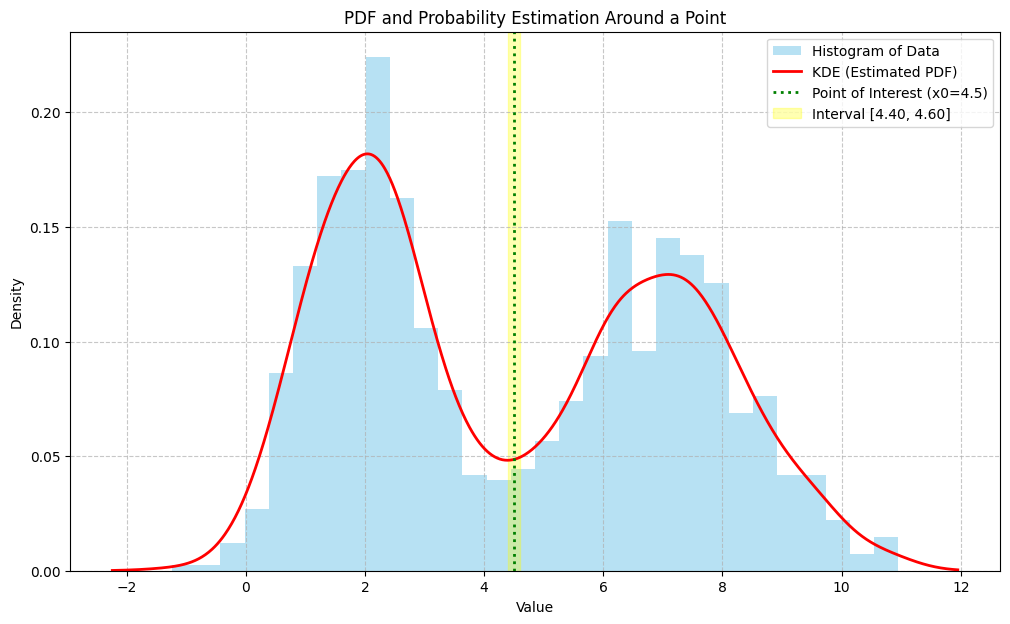

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# --- สร้างข้อมูลและ KDE เหมือนเดิม ---
np.random.seed(42)
data_1 = np.random.normal(loc=2, scale=1, size=500)
data_2 = np.random.normal(loc=7, scale=1.5, size=500)
data = np.concatenate((data_1, data_2))
data_reshaped = data[:, np.newaxis]
x_plot = np.linspace(min(data) - 1, max(data) + 1, 1000)[:, np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_reshaped)
log_dens = kde.score_samples(x_plot)
pdf_values = np.exp(log_dens) # ค่า PDF ที่ประมาณได้

# --- การหาความน่าจะเป็นรอบจุดที่สนใจ ---

# 1. เลือกจุด x ที่สนใจ
point_of_interest = 4.5

# 2. กำหนดช่วงเล็กๆ รอบจุดนั้น (epsilon)
epsilon = 0.1 # ความกว้างครึ่งหนึ่งของช่วงที่เราสนใจ (ดังนั้นช่วงรวมคือ 2 * epsilon)
lower_bound = point_of_interest - epsilon
upper_bound = point_of_interest + epsilon

# 3. หาสค่า PDF ที่จุดนั้น (หรือค่าที่ใกล้เคียงที่สุดใน x_plot)
# ค้นหาดัชนีของ x_plot ที่ใกล้เคียงกับ point_of_interest ที่สุด
idx_x_interest = np.argmin(np.abs(x_plot - point_of_interest))
pdf_at_point = pdf_values[idx_x_interest]

# 4. ประมาณความน่าจะเป็นใน "ช่วงเล็กๆ" นั้น
# P(x_0 - epsilon <= X <= x_0 + epsilon) approx f_hat(x_0) * (2 * epsilon)
estimated_prob_around_point = pdf_at_point * (2 * epsilon)

print(f"--- Estimating Probability Around a Specific Point ---")
print(f"Point of Interest (x0): {point_of_interest:.2f}")
print(f"Half-width of interval (epsilon): {epsilon:.2f}")
print(f"Full interval: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Estimated PDF value at {point_of_interest:.2f} (f_hat(x0)): {pdf_at_point:.4f}")
print(f"Estimated Probability in interval [{lower_bound:.2f}, {upper_bound:.2f}]: {estimated_prob_around_point:.4f}")

# --- การตรวจสอบด้วยการหาพื้นที่ใต้กราฟจริงในช่วงนั้น (แม่นยำกว่า) ---
# หาดัชนีของ x_plot ที่อยู่ในช่วง [lower_bound, upper_bound]
idx_start_interval = np.argmin(np.abs(x_plot - lower_bound))
idx_end_interval = np.argmin(np.abs(x_plot - upper_bound))

# คำนวณพื้นที่ใต้กราฟโดยใช้ Trapezoidal rule
prob_from_integration = np.trapz(pdf_values[idx_start_interval:idx_end_interval+1],
                                 x=x_plot[idx_start_interval:idx_end_interval+1].flatten())
print(f"Probability from numerical integration over interval: {prob_from_integration:.4f}")


# --- แสดงผลด้วยกราฟ ---
plt.figure(figsize=(12, 7))
plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram of Data')
plt.plot(x_plot, pdf_values, color='red', linestyle='-', linewidth=2, label='KDE (Estimated PDF)')

# ทำเครื่องหมายจุดที่สนใจ
plt.axvline(x=point_of_interest, color='green', linestyle=':', linewidth=2, label=f'Point of Interest (x0={point_of_interest})')

# เน้นช่วงที่เราประมาณความน่าจะเป็น
plt.axvspan(lower_bound, upper_bound, color='yellow', alpha=0.3, label=f'Interval [{lower_bound:.2f}, {upper_bound:.2f}]')

plt.title('PDF and Probability Estimation Around a Point')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.show()